<h2>Daniel Vasilyonok</h2>
<h3>Python for Data Science CSCI E - 29</h3>
<h3>Natural Language Identification System - Graduate Project</h3>

<p>
In this project, I pulled text data from European Parliament Proceedings in 21 languages.
Using Scikit-Learn, I transformed the raw text into a numerical feature matrix, and trained
a Multinomial naive bayes probability model to classify input language with greater than 99% accuracy.
</p>

<p> 
Data Source: http://www.statmt.org/europarl/    
</p>

In [1]:

# Required libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import sent_tokenize
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:

# regular expression pattern used to filter out anything between < >
# Non predictive speaker information in english is always in between those two symbols

pattern = r'<(!?).*>'

# Max length of language transcription
# Ensure each language has similar amount of representation (Balanced Dataset)
MAX_LENGTH_TRANSCRIPTION = 150000

In [3]:

# Map language index to natural language

labels = { 
          1.0:'Danish', 2.0:'German',
          3.0: 'Greek', 4.0: 'English', 
          5.0: 'Spanish',6.0: 'Finnish', 
          7.0: 'French', 8.0: 'Italian', 
          9.0: 'Dutch', 10.0: 'Portuguese', 
          11.0: 'Swedish', 12.0: 'Bulgarian',
          13.0: 'Czech', 14.0: 'Estonian',
          15.0: 'Hungarian', 16.0: 'Lithuanian',
          17.0: 'Latvian', 18.0: 'Polish',
          19.0: 'Romanian', 20.0: 'Slovak',
          21.0: 'Slovenian'
          }

# Map language to language code and file name

language_codes_files = {
    'Danish': ['da', '/ep-00-01-17.txt'], 'German': ['de', '/ep-00-01-17.txt'], 
    'Greek': ['el', '/ep-00-01-17.txt'], 'English': ['en', '/ep-00-01-17.txt'], 
    'Spanish': ['es', '/ep-00-01-17.txt'], 'Finnish': ['fi', '/ep-00-01-17.txt'],
    'French': ['fr','/ep-00-01-17.txt'], 'Italian': ['it', '/ep-00-01-17.txt'], 
    'Dutch': ['nl', '/ep-00-01-17.txt'], 'Portuguese': ['pt', '/ep-00-01-17.txt'], 
    'Swedish': ['sv', '/ep-00-01-17.txt'], 'Bulgarian': ['bg', '/Bulgarian.txt'],
    'Czech': ['cs', '/Czech.txt'], 'Estonian': ['et', '/Estonian.txt'],
    'Hungarian': ['hu', '/Hungarian.txt'], 'Lithuanian': ['lt', '/Lithuanian.txt'],
    'Latvian': ['lv', '/Latvian.txt'], 'Polish': ['pl', '/Polish.txt'],
    'Romanian': ['ro', '/Romanian.txt'], 'Slovak': ['sk', '/Slovak.txt'],
    'Slovenian': ['sl', '/Slovenian.txt']
}

# These languages need multiple files combined to get a transcription of length
# >= MAX_LENGTH_TRANSCRIPTION
limited_raw_text = ['Bulgarian', 'Czech', 'Estonian', 'Hungarian', 'Lithuanian',
                     'Latvian', 'Polish', 'Romanian', 'Slovak', 'Slovenian']


In [4]:
# Helper Functions

def combine_text_files(language_code, language):
   
    '''
    Goal: Certain languages do not have a single file of length >= MAX_LENGTH_TRANSCRIPTION
          This function will combine these files for this sort of language into one language
          transcription, and then write the transcription to a single file.
    
    @param: (string) language_code is the 2 character code of the language
    @param: (string) language is the English name of the language         
    '''    
    
    file_name_list = os.listdir('language_data/txt/' + language_code + '/')
    language_transcription = ''
    for file_name in file_name_list:
        if(len(language_transcription) >= MAX_LENGTH_TRANSCRIPTION):
            break;
        path = os.getcwd() + '/language_data/txt/' + language_code + '/' + file_name
        with open(path) as f:
            contents = f.read()
            language_transcription += contents
    
    write_path = os.getcwd() + '/language_data/txt/' + language_code + '/' + language + '.txt'
    with open(write_path, 'w') as f:
        f.write(language_transcription)

def read_languages_data(path):
    '''
    Goal: Read language data from file path into a list containing one massive string
    
    @param path: (string) file path pointing to the raw natural language text
                 Original file data source found here: http://www.statmt.org/europarl/
    @return language_transcription: (list) language_transcription is a list of one string containing the whole text
    '''
    with open(path) as f:
        language_transcription = f.read()
        language_transcription = language_transcription[:MAX_LENGTH_TRANSCRIPTION]
    return language_transcription

def clean_sentences(sentences):
    '''
    Goal: Filter out non predictive text about speaker using regular expression pattern
    
    @param sentences: (list) sentences is a list of strings, where each string is a sentence.
                       Note: The raw language_transcription should be tokenized by sentence prior
                       to being passed into this function.
    '''
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(pattern,'',sentence)

def combine_language_data(sentences, language_index):
    '''
    Goal: Transform list of string sentences into np.array, and stack horizontally with an np.array containing 
          the sentence's language_index, which maps to the sentence language. Essentially, apply label to data.
    
    @param sentences: (list) sentences is a list of strings that has had speaker information filtered out
    @param language_index: (float) language_index is a float that maps to a specific language in the labels dictionary
    @return language_data: (np.array) return an np.array of shape (# of sample sentences, 2 )
    '''
    sentences = np.array(sentences)
    sentences = sentences.reshape(sentences.shape[0],1)
    target = np.zeros((sentences.shape[0],1))
    target += language_index
    language_data = np.hstack((sentences, target))
    return language_data

def test_languages(X_test, true_values, predictions):
    '''
    Goal: Visualize the ~99% prediction accuracy by comparing,
        1. natural language sentence
        2. predicted natural language
        3. true natural language
    
    @param X_test: (np.array) X_test is a np.array containing the unseen data from the test set
    @param true_values: (np.array) true_values is a np.array containing the true language_index labels
    @param predictions: (np.array) predictions is a np.array containing the predicted language_index labels
    '''
    
    for i, sentence in enumerate(X_test):
        prediction = float(predictions[i])
        true_value = float(true_values[i])
        print("Prediction: " + str(labels[prediction]))
        print("Actual Language: " + str(labels[true_value]))
        print("Input Sentence: ")
        print(sentence)
        print('\n')

def shuffle_rows(languages):
    '''
    Goal: Shuffle rows of 2D np.array with language data
    
    @param languages: un-mixed 2D np.array with language sentence features, and language_index labels
    @return shuffled_languages: shuffled by row, 2D np.array 
    '''
    
    index = np.arange(0, len(languages))
    np.random.shuffle(index)
    shuffled_languages = languages[index,:]
    return shuffled_languages
    
def preproccess_raw_data(file_paths):
    '''
    Goal: Run all data preprocessing helper functions
    
    @param file_paths: (list) file_paths is a list of string file paths. Each file path string
                        points to a raw text file from the European Parliament Proceedings.
    @return languages: (np.array) languages is a 2D np.array of shape (# sentences, 2)
                        The first dimension has the a sentence, and the second dimension
                        has the language_index label, that maps to the language.
    '''
    
    # Combine transcriptions of subset languages into a single file to ensure
    # each file will have len >= MAX_LENGTH_TRANSCRIPTION
    language_codes_files_subset = dict( (key, language_codes_files[key] ) for key in limited_raw_text if key in language_codes_files )
    for language in language_codes_files_subset.keys():
        combine_text_files(language_codes_files_subset[language][0], language)
    
    # Read all raw text data from file paths
    language_transcriptions = [ read_languages_data(path) for path in file_paths ]
    
    # tokenize each raw text string into a list of sentences
    for i, language_transcription in enumerate(language_transcriptions):
        language_transcriptions[i] = sent_tokenize(language_transcription)
    
    # Remove information about speakers using a regular expression pattern
    for sentences in language_transcriptions:
        clean_sentences(sentences)
    
    # Combine each language with its language_index
    languages = [ combine_language_data(sentences,i+1) for i,sentences in enumerate(language_transcriptions) ]
    
    # Vertically stack all data into one 2D np.array
    languages =  np.vstack((languages))
    
    # Shuffle languages by row
    languages = shuffle_rows(languages)
    
    return languages
    

In [5]:
# Get all file paths

file_paths = [ os.getcwd() + '/language_data/txt/' + language_codes_files[language][0] + language_codes_files[language][1] for language in language_codes_files ]

# Preprocess all raw text into a form suitable for TfidfVectorizer
languages = preproccess_raw_data(file_paths)
languages

array([[ '\nUvedl jsem, že více než 80 milionů lidí je v dnešní Evropské unii ohroženo chudobou.',
        '13.0'],
       [ '\nDie Verkehrssicherheit bestimmte in letzter Zeit häufig die Negativschlagzeilen: Das Eisenbahnunglück nahe dem Londoner Bahnhof Paddington, das furchtbare Eisenbahnunglück in Norwegen, zwei Flugzeugabstürze, bei denen EU-Bürger zu Schaden kamen, und die von der Erika vor der bretonischen Küste verursachte Naturkatastrophe sind Ereignisse, die allein in den letzten vier Monaten zu verzeichnen waren.',
        '2.0'],
       [ 'Acesta constituie un domeniu pe care noi, ca societate, nu ne mai putem permite să-l ignorăm.',
        '19.0'],
       ..., 
       [ '\nHärra juhataja, ma sooviksin juhtida oma kolleegide tähelepanu külaliste rõdul viibivale Moldova parlamendis esindatud kolme opositsioonipartei juhile, kes selleks aruteluks siia on tulnud, - Dorin Chirtoacă, kes on Chişinău linnapea ning Moldova Liberaalse Partei aseesimees; Vladimir Filat, kes on Mold

In [6]:
languages.shape

(20945, 2)

In [7]:
# Split data into raw features and labels

language_features = languages[:,0]
language_targets = languages[:,1]

Ensure Dataset is relativley balanced.

In [8]:
unique, counts = np.unique(language_targets, return_counts=True)
dict(zip(unique, counts))

{'1.0': 1063,
 '10.0': 814,
 '11.0': 975,
 '12.0': 1030,
 '13.0': 1161,
 '14.0': 1184,
 '15.0': 1019,
 '16.0': 1213,
 '17.0': 1174,
 '18.0': 1121,
 '19.0': 958,
 '2.0': 912,
 '20.0': 1163,
 '21.0': 1173,
 '3.0': 760,
 '4.0': 890,
 '5.0': 860,
 '6.0': 880,
 '7.0': 815,
 '8.0': 802,
 '9.0': 978}

In [9]:
# Split data into training and test set
# Train on 70% of data, Test on remaining 30%

X_train, X_test, y_train, y_test = train_test_split(language_features, 
                                                    language_targets,
                                                    test_size = 0.3,
                                                    random_state = 42)

In [10]:
'''
       Machine Learning Pipeline

    1. Preprocess raw sentence features with TfidfVectorizer. Convert raw sentence text into numerical feature matrix.
       TfidfVectorizer is the combination of CountVectorizer, and TfidfTransformer.
       TfidfVectorizer : tfidf = Term frequency inverse document frequency 
                      
                         analyzer = 'char', the raw sentence feature is tokenized into characters
                         ngram_range = (1,3), character n_grams are formed with character length
                                              from 1 to 3
                      
                         The count of each ngram is recorded and divided 
                         by the total ngrams in the sentence (CountVectorizer) This is term frequency.
                         This term frequency is scaled down by being multiplied by how common it is in all sentences,
                         i.e. by 1 + log(# sentences / # of sentences that contain the ngram). 
                         If an ngram is highly recurrent in the sentences the value of the above log ratio 
                         approaches 0, and lowers the tfidf score.
                      
                         The resulting feature matrix has the sentence/row index, and the ngram_index along with
                         its tfidf score. This can be passed into the model.
                      
    2. Naive Bayes MultinomialNB model
       Features are assumed to be generated from a simple multinomial distribution. 
       The data is modeled with best fit multinomial distribution.
       The multinomial distribution describes the probability of observing counts among a number of categories.
       Thus, this model is a good fit for observing count frequency of ngrams as represented by tfidf scores.
    
'''

tfidf_vect = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
model = MultinomialNB()
text_clf = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model),
                    ])

In [11]:

# Train model with pipeline classifier

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [12]:

# Make predictions on unseen test data with trained classifier

predictions = text_clf.predict(X_test)

In [13]:

# Measure accuracy

accuracy_score(y_test,predictions)

0.99140674729471678

<h1>Cross Validated Accuracy</h1>

In [14]:

# alternate train and test set through cross validation to yield a more trustworthy accuracy

scores = cross_val_score(text_clf, language_features, language_targets, cv=5)
print("Mean cross-validation accuracy: " + str(scores.mean()))

Mean cross-validation accuracy: 0.991550629564


In [15]:

# Visualize Performance

test_languages(X_test, y_test, predictions)

Prediction: Finnish
Actual Language: Finnish
Input Sentence: 
Meillä on siinä asiassa näköjään ongelmia.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Ma olen vägagi selle idee poolt.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 
On välttämätöntä, että kasvun oloissa hyöty jakautuu tasaisemmin, mutta näitä koeteltuja syrjäisiä ja syrjäisimpiä tai saarialueita vaivaa vielä ankarammin vielä hankalampi ongelma, eli sen kasvun puuttuminen, joka on ollut maailmanlaajuisesti ominaista kahdelle kuluneelle vuosikymmenelle.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Grški proračun - in dejansko vsi proračuni, kjer koli že so - se morajo zmanjšati.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
- (CS) Härra juhataja, härra volinik, daamid ja härrad, nii nõukogu kui ka parlament jälgivad suure rahutusega Moldovas arenevaid sündmusi seoses 5. aprilli parlamendivalimistega.


Prediction: Estonian
Actual Language: Esto

Input Sentence: 

K překonání krize je například zapotřebí, aby fungování stálého fondu také zohledňovalo konkrétní situaci těch členských států, jež v současnosti ze svého veřejného dluhu platí vyšší úrokové sazby.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Borosso kungs to zina.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Teraz jest czas, żeby przedstawić sprawy tak, jak one wyglądają.


Prediction: French
Actual Language: French
Input Sentence: 
Il me semble que c'est une bonne formule.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
Rád bych panu předsedovi položil otázku.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
Tai reiškia, kad operatorius niekada nesijaus patenkintas, jei bus rizika.


Prediction: French
Actual Language: French
Input Sentence: 
Je le félicite de son excellent rapport.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Toda proglasitev romunskega ambasadorja v Chişina

Input Sentence: 
Във връзка с това е важно също да подкрепим напълно работата на специалния представител на Европейския съюз в Молдова.


Prediction: French
Actual Language: French
Input Sentence: 
On cherche en vain dans ce document une trace du principe central qui appelle les États membres à élaborer les programmes avec les communes et les régions, mais aussi avec les acteurs locaux, les organisations économiques et sociales, les ONG, les syndicats, les syndicats patronaux, les associations féminines, les initiatives citoyennes et les initiatives locales pour l'emploi.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 

Nors šios misijos nepakeičia valstybės atsakomybės ir pareigos tirti žmogaus teisių pažeidimus ir patraukti pažeidėjus atsakomybėn, jos turėtų padėti nušviesti vėliausius rinkimus ir po jų sekusius įvykius.


Prediction: Greek
Actual Language: Greek
Input Sentence: 

Από την έκτη περιοδική έκθεση για τις περιφέρειες, μπορούμε να συμπεράνουμε ότι τα


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Berend og lykønske ham for kvaliteten af det arbejde, han har udført.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 

Másodsorban pedig ott van a megközelítés kérdése.


Prediction: French
Actual Language: French
Input Sentence: 
Puis , nous ferons comme d' habitude : nous entendrons un orateur pour et un orateur contre.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Evans, en særlig glæde over at kunne holde min første tale i Parlamentet om dette meget vigtige spørgsmål, især da jeg repræsenterer en del af Det Forenede Kongerige, West Midlands, som tidligere har haft glæde af mål 2-støtte.


Prediction: French
Actual Language: French
Input Sentence: 
C'est pourquoi mon groupe rejette résolument la proposition du groupe socialiste.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Hvala za pozornost.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 

Ta

Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 

Priprava vrhunskega srečanja euroobmočja 11. marca 2011 (razprava) 

Naslednja točka je izjava predsednika Komisije o pripravi vrhunskega srečanja euroobmočja 11. marca 2011 (2011/2615/RSP).


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Vi glæder os alle sammen over, at domstolen har frifundet ham og understreget, at adgangen til miljøinformationer også er konstitutionel ret i Rusland.


Prediction: German
Actual Language: German
Input Sentence: 
Im Ergebnis dieses Berichtes machen wir die Kommission darauf aufmerksam, daß die rechtlichen Grundlagen für eine Zusammenarbeit zwischen Regionen und Mitgliedstaaten und Beitrittskandidatenländern verbessert werden müssen, und weisen auf die besondere Notwendigkeit der Budgetkonsolidierung als Voraussetzung für den Erfolg der Wirtschafts- und Währungsunion und der Erweiterung nach Osten hin.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
Vad sä

Komisijas loceklis.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
A czy wiedzą Państwo, co mówi Moody?


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Г-н член на Комисията, ако идеите Ви бъдат включени в този пакт и бъде възстановено икономическото и социалното равновесие, както твърдите Вие, пактът отново ще бъде насочен в правилната посока.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Need ettepanekud on praegu arutlusel ka siin parlamendis ja nõukogus.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 

Senhor Presidente, é necessário que as orientações possam dirigir correctamente e aumentar a eficácia dos programas no período crucial de 2002-2006, para que o desenvolvimento sustentável e o reforço do emprego, especialmente das mulheres e dos jovens, se tornem uma realidade, e para que seja assegurado o equilíbrio entre as políticas económica, social e ambiental.


Prediction: Lithuanian
Actual Language: L

Input Sentence: 
Teisest küljest peavad opositsiooni esindajad tegema konstruktiivset koostööd võimul oleva parteiga ning austama valimistulemusi.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 
Os nossos aditamentos apontam, pois, para a necessidade de prever estratégias de saída práticas e exequíveis, por forma não apenas a assegurar a necessária garantia contra a manutenção de custos desnecessários, frequentemente a cargo do contribuinte, mas também a evitar a bem conhecida síndrome que consiste em investir novos recursos na tentativa de recuperar os prejuízos, muito embora as probabilidades de êxito sejam escassas ou mesmo nulas.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
När det gäller den informella ekonomin som ni tar upp i ert betänkande, vet jag naturligtvis att analys och framtagning av statistik på detta område är beroende av uppgifternas tillförlitlighet och såsom Cocilovo också sade föreligger det ett tillförlitlighetsproblem när 

Actual Language: Danish
Input Sentence: 
Effekten af projekter, der er gennemført ved hjælp af unionsstøtte, svækkes ofte ved en langsom beslutningstagning og kompliceret forvaltning.


Prediction: English
Actual Language: English
Input Sentence: 
As you know, like Mr Rack, I come from a transit country, where this issue plays a particularly important role.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Г-жо председател, за отговора на този последен и решаващ въпрос непременно трябва да се вземе под внимание отвореното писмо, съдържащо девет препоръки, предадени вчера на чешкото председателство от четиринадесет молдовски защитници на гражданското общество.


Prediction: Greek
Actual Language: Greek
Input Sentence: 
Σας ομολογώ ότι, επί του παρόντος, τα πράγματα μου φαίνονται κάπως συγκεχυμένα.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
Schroedter incluye bastantes observaciones importantes, y la felicito por ello.


Prediction: Latvian
Actual L

Prediction: Polish
Actual Language: Polish
Input Sentence: 
- (IT) Pani przewodnicząca, panie i panowie!


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 

Nazadnje pa menim, in to je moja zadnja točka, da je čas, gospod Barroso, da v najkrajšem možnem času predstavite pobudo o kriznem mehanizmu za banke, in sicer ne na nacionalni ravni, kot je bilo navedeno, ampak na evropski.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
Proto je tak důležité spojit věci dohromady, protože zde existují určité přesahy.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
Wij vinden het zeer positief dat de rapporteur in zijn eigen conclusies het voorstel van onze commissie heeft overgenomen om in cohesielanden de infrastructuur van onderzoek te verbeteren door hogescholen en onderwijsinstellingen te vestigen op plaatsen waar ze de bewoners van achterstandsregio's beter kunnen bedienen en het voor geschoolde mensen makkelijker kunnen maken in hun eigen regio te bl



Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Понастоящем Комисията казва на правителствата, че тя трябва да продължи да има определена роля в този пакт за конкурентоспособност, но не поради лоялност към институцията, не от институционален еготизъм, а защото несъмнено считам, че Комисията, както и общностният подход, са гаранция, за да избегнем разделенията между еврозоната и останалата част от Европа.


Prediction: German
Actual Language: German
Input Sentence: 
Diesem Punkt wird - wieder einmal - nicht die nötige Aufmerksamkeit gewidmet: Das geht nun schon all die fünf Jahre so, die ich Mitglied des Parlaments bin, und immer wieder habe ich auf das Problem hingewiesen.


Prediction: English
Actual Language: English
Input Sentence: 

In conclusion, while key infrastructure projects have been supported by the European Regional Development Fund and the Cohesion Fund, we should remember that the European Social Fund has played a very important role in helping the le

Input Sentence: 

Moldavská republika je náš sused.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
Detta har tyvärr inte skett, och den som bär ansvaret för detta är inte Bernié utan det förutvarande utskottet.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 

I fortsättningen måste man också fundera på att utveckla indikatorer för att åtgärderna skall kunna riktas in på rätt plats vid rätt tidpunkt.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Donos portugalskih obveznic je v ponedeljek padel na 7.6 %.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Det kunne f.eks.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Škoda nastaja v zaporednih valovih na sovražnikovi strani in na osebju, ki uporablja to orožje: na primer sindrom zalivske vojne in balkanski sindrom.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
Amikor egy olyan ország, mint amilyen Görögország ilyen radikális mért


Herr Präsident, Herr Kommissar, meine Damen und Herren!


Prediction: Danish
Actual Language: Danish
Input Sentence: 

Det tredje, som jeg gerne vil påpege, er, at vi generelt er enige i retningslinjerne, for så vidt de ikke strider mod de bemærkninger, som vi er fremkommet med.


Prediction: French
Actual Language: French
Input Sentence: 

Pour ce qui est du thème proprement dit, je pense que les citoyens d'Europe doivent pouvoir compter sur le fait que les marchandises transportées sur les routes, les voies ferrées et autres voies de transport européennes, qu'il s'agisse ou non de marchandises dangereuses, sont transportées d'une manière aussi sûre que possible.


Prediction: Italian
Actual Language: Italian
Input Sentence: 
E' noto che spetta agli Stati membri ridistribuire una parte dei finanziamenti.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
Creo que el principio de estabilidad relativa es un principio legal fundamental de las políticas pesqueras comunitaria


(DE) Elnök asszony, Gauzčs úr kérésére reagálva szeretném elmondani, hogy egy alternatív állásfoglalás ellenében vissza kívánjuk vonni a tervezetet.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
Javaslatunk gazdasági és monetáris uniónk gazdasági pillérének a továbbfejlesztése.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Stranke, ki so si pridobile sedeže v novem parlamentu, se morajo dogovoriti o realni rešitvi, ki upošteva demokratična načela.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Viimase 15 aasta jooksul oleme Moldova rahvaga lähedaselt ja usalduslikult koos töötanud.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 

Vi får inte glömma att dessa politiska insatser, när de är effektiva, är synliga också för de europeiska medborgarna, som drar nytta av dem och som ser en direkt förbättring av sin livskvalitet.


Prediction: French
Actual Language: French
Input Sentence: 

Comme vous avez pu le co


Deshalb treten wir für eine Landwirtschaftspolitik und eine ländliche Entwicklung ein, die mit unseren Zielen im Einklang steht, sowie dafür, daß die ländlichen Gebiete an der Schwelle zum 21.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
Vi har sagt att detta går för sig, om kommissionen inte vill göra klart program 2000 redan i januari, då gör vi det i februari.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
Y yo agregaría, pues muchos de ustedes de inmediato señalaron lo que les parecía un olvido, las economías regionales de las regiones europeas desfavorecidas por su lejanía, ya se trate de regiones periféricas, insulares o, por supuesto, de las regiones ultraperiféricas que son las más alejadas.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Derfor stemmer vi for den.


Prediction: German
Actual Language: German
Input Sentence: 
Deshalb wundert es natürlich niemanden, daß bereits im Vorfeld der neuen Strukturfondsverordnung die Fo

Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Meil on suur hulk spetsiifilisi andmeid, mis viitavad valimistel manipuleerimisele.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Междуправителственият подход никога не е работил в рамките на Европейския съюз.


Prediction: Polish
Actual Language: Polish
Input Sentence: 

(RO) Pani przewodnicząca!


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Oznaczałoby to zrównoważony rozwój.


Prediction: Greek
Actual Language: Greek
Input Sentence: 
Θα έχετε ενημερωθεί από τον τύπο και την τηλεόραση ότι συνέβησαν ορισμένες εκρήξεις βομβών και φόνοι στη Σρι Λάνκα.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Šajā valstī ir pieaugošs procents deformētu bērnu, īpaši Bagdādē.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 

Liikenneturvallisuus on päässyt äskettäin ikävällä tavalla uutisiin: Lontoon Paddingtonin junaturma, hirvittävä Norjassa sattunut junaturma, kaksi

Actual Language: Hungarian
Input Sentence: 

Elnök asszony, a gazdasági kormányzás és a bankszektor szabályozásának szándékos nemzeti és európai szintű kikerülése taszított minket a válságba, és a válság mindenki számára egyértelművé vált a munkahelyek csökkenésén, a növekedés hiányán, az elveszített nyugdíjellátásokon stb.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
Jag tänker särskilt på ISPA-instrumentet som det är mitt ansvar att genomföra under de kommande veckorna.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
De skall inte handla om att ändra inriktning och politik när man kommit halvvägs genom projektet, vilket resulterar i oundvikliga förseningar och outnyttjade medel, i synnerhet mot bakgrund av det nya budgetkravet.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 
A venit timpul unei strategii cuprinzătoare a UE care să conducă la un plan concret de acţiuni care să urmărească combaterea tuturor formelor de violenţă împot

Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Ето защо мисля - и бих искал да подкрепя напълно присъстващия член на Комисията за това - че ние в Европа трябва да използваме всички възможности, с които разполагаме в момента в борбата за свобода на отделните граждани, за свобода на печата и за истинска демокрация.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
Mijn tweede opmerking: door deze richtlijn bereiken we meer veiligheid bij het vervoer en het laden en lossen van gevaarlijke goederen.


Prediction: German
Actual Language: German
Input Sentence: 
Vielleicht darf ich ihn auch daran erinnern, daß der Vorsitzende seiner Partei, Herr Hague, als er noch Minister für Wales war, sämtliche Regeln in bezug auf die Zusätzlichkeit verletzt hat, die man nur verletzen kann, und dafür von Kommissionsmitglied Wulf-Mathies schriftlich entschieden zur Ordnung gerufen wurde.


Prediction: Italian
Actual Language: Italian
Input Sentence: 
Questa settimana terremo in



Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 

Aštunta, norėčiau pabrėžti struktūrinių fondų, visų pirma Europos socialinio fondo kaip pagrindinės priemonės, kuria padedama valstybėms narėms kovoti su skurdu ir socialine atskirtimi, svarbą.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
Valdybas sudaro dešimt vyrų ir tik viena moteris, o tai reiškia, kad vyrų kvota de facto yra 90 proc.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 

Nedávna štúdia BBC vo Veľkej Británii preukázala, že 24 hodín po masívnom bombardovaní na Balkáne, bola nameraná historicky najvyššia miera atmosférickej rádioaktivity na severe Anglicka.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Tieši tāpēc mēs darām šo darbu, un tāpēc es arī vēlētos apsveikt Barroso kungu saistībā ar idejām, kuras viņš mums šeit izklāstīja.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
Den femte punkten gäller de små och medelstora föret



Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Küll aga kuuleme selle tulemusest, nimelt turvavõrgu laiendamisest.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
Součástí je vypracování režimu postupného zákazu výroby přijatelného pro všechny členské státy stejně jako skladování, obchodování i konečného data zákazu použití.


Prediction: Swedish
Actual Language: German
Input Sentence: 
Herr Kommissar!


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 

Viņš runāja par notikumiem Ēģiptē un citviet pasaulē, norādot, ka tas, ka cilvēki protestē, cenšoties panākt demokrātiskas pārvaldes ieviešanu, ir brīnišķīgi.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
Ni kunde inte närvara vid talmanskonferensen förra torsdagen.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
Navrhla jsem pobídku pro platbu před termínem splatnosti, prémii, která odměňuje brzké splacení.


Prediction: Italian
Actual Language: Italian
Input Sen


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Ето защо институцията, която представляваме, е длъжна да въведе конкретни стратегии и програми.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
Pakt konkurencieschopnosti pani Merkelovej a pána Sarkozyho zahrnuje šesť konkrétnych opatrení.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
Wat deze redenen ook mogen zijn, we hebben dit verslag over de richtsnoeren voor de programma' s in de periode 2000-2006 vandaag in ieder geval in behandeling genomen, en net als de rest van de Commissie denk ik dat het op het juiste moment komt.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
Okolo 70 % územia Iraku je kontaminovaných, a dokonca ani dnes si nie sme istí rozsahom hrozných ľudských škôd, ktoré spôsobil ochudobnený urán.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 

Toivoisin, että jäsen Barón Crespo, pyynnön esittäjä, käyttäisi puheenvuoron ja perustelisi pyyntöns

Input Sentence: 

Ik zou de heer Barón Crespo willen vragen zijn verzoek om inschrijving hier toe te lichten.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
W naszym interesie leży ugruntowanie demokracji w Mołdawii oraz dalsze zbliżanie się tego kraju do Unii Europejskiej.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Igal juhul antakse ideed edasi ja vabatahtlikkuse vaim moodustab protsessist ühe osa, uskuge mind, sest peame selgelt lootma, et kõik teised Euroopa riigid suudavad teha seda, mida Belgia on teinud.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 
Influenţa mass-mediei are legătură cu această escaladare, dar escaladarea se produce şi pe fondul crizei.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Przez ostatnie 15 lat prowadziliśmy ścisłą współpracę z obywatelami Mołdawii, opartą na zaufaniu.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Не на последно място кризата в Кишинев показв

Input Sentence: 

Todavia, a proposta da Comissão não teve em conta todos os aspectos, designadamente, o clima frio das regiões setentrionais.


Prediction: Danish
Actual Language: Danish
Input Sentence: 

Det er vigtigt at identificere kvalifikationer og potentiale for vores regioner i den højteknologiske sektor.


Prediction: English
Actual Language: English
Input Sentence: 

We look to the Commission to deal with points in relation to additionality.


Prediction: Danish
Actual Language: Danish
Input Sentence: 

Transport af farligt gods ad vej

Næste punkt på dagsordenen er betænkning (A5-0104/1999) af Koch for Udvalget om Regionalpolitik, Transport og Turisme om forslag til Europa-Parlamentets og Rådets direktiv om ændring af direktiv 94/55/EF om indbyrdes tilnærmelse af medlemsstaternes lovgivning om transport af farligt gods ad vej (KOM(1999) 158 - C5-0004/1999 - 1999/0083(COD)).


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 

Desearía que el Sr. Barón Crespo, au

<h1>Classification Report</h1>

In [16]:
# Target order based on ordering of default classification report
targets = ['Danish', 'Portuguese', 'Swedish',
           'Bulgarian', 'Czech', 'Estonian',
           'Hungarian', 'Lithuanian', 'Latvian',
           'Polish', 'Romanian', 'German', 
           'Slovak', 'Slovenian', 'Greek', 
           'English', 'Spanish', 'Finnish', 
           'French', 'Italian', 'Dutch']

In [17]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

        1.0       0.99      0.99      0.99       320
       10.0       1.00      1.00      1.00       220
       11.0       0.97      0.99      0.98       297
       12.0       1.00      1.00      1.00       322
       13.0       0.99      0.98      0.98       360
       14.0       0.97      0.99      0.98       334
       15.0       1.00      0.99      1.00       337
       16.0       1.00      0.99      1.00       352
       17.0       1.00      1.00      1.00       358
       18.0       1.00      0.99      0.99       355
       19.0       0.99      0.99      0.99       282
        2.0       0.99      1.00      0.99       260
       20.0       0.99      0.96      0.98       339
       21.0       0.98      1.00      0.99       336
        3.0       1.00      1.00      1.00       251
        4.0       1.00      1.00      1.00       284
        5.0       1.00      0.98      0.99       233
        6.0       1.00      0.98      0.99   

In [18]:

print(classification_report(y_test, predictions, target_names=targets))

             precision    recall  f1-score   support

     Danish       0.99      0.99      0.99       320
 Portuguese       1.00      1.00      1.00       220
    Swedish       0.97      0.99      0.98       297
  Bulgarian       1.00      1.00      1.00       322
      Czech       0.99      0.98      0.98       360
   Estonian       0.97      0.99      0.98       334
  Hungarian       1.00      0.99      1.00       337
 Lithuanian       1.00      0.99      1.00       352
    Latvian       1.00      1.00      1.00       358
     Polish       1.00      0.99      0.99       355
   Romanian       0.99      0.99      0.99       282
     German       0.99      1.00      0.99       260
     Slovak       0.99      0.96      0.98       339
  Slovenian       0.98      1.00      0.99       336
      Greek       1.00      1.00      1.00       251
    English       1.00      1.00      1.00       284
    Spanish       1.00      0.98      0.99       233
    Finnish       1.00      0.98      0.99   

In [19]:
language_names = list(language_codes_files.keys())
plt.figure(figsize=(32, 32))
cm = confusion_matrix(y_test, predictions)

ax = sns.heatmap(cm, annot = True, fmt = "d")

ax.set_xlabel('Predicted Language')
ax.set_ylabel('Actual Language')
ax.set_title('Language Identification Confusion Matrix')
ax.set_xticklabels(targets)
ax.set_yticklabels(targets)

[Text(0,0.5,'Danish'),
 Text(0,1.5,'Portuguese'),
 Text(0,2.5,'Swedish'),
 Text(0,3.5,'Bulgarian'),
 Text(0,4.5,'Czech'),
 Text(0,5.5,'Estonian'),
 Text(0,6.5,'Hungarian'),
 Text(0,7.5,'Lithuanian'),
 Text(0,8.5,'Latvian'),
 Text(0,9.5,'Polish'),
 Text(0,10.5,'Romanian'),
 Text(0,11.5,'German'),
 Text(0,12.5,'Slovak'),
 Text(0,13.5,'Slovenian'),
 Text(0,14.5,'Greek'),
 Text(0,15.5,'English'),
 Text(0,16.5,'Spanish'),
 Text(0,17.5,'Finnish'),
 Text(0,18.5,'French'),
 Text(0,19.5,'Italian'),
 Text(0,20.5,'Dutch')]

<h1> 21x21 Confusion Matrix</h1>

<p> 
The well defined diagonal is a visual representation 
of the good performance of this language classifier.
Although this model performs quite well, there are a few misclassifications.
The confusion matrix gives insight into where the model makes errors.
It's interesting to note that errors usually occur among languages from a related language
family. For example, the model predicts Slovak 5 times when the actual language is Czech, and
it predicts Czech 3 times when the actual language is Slovak. There are some weird cases where 
the model predicts a language that's not from a similar family, and this could be the cause of a small amount of labeled bad data that was not cleaned from the raw dataset.
</p>

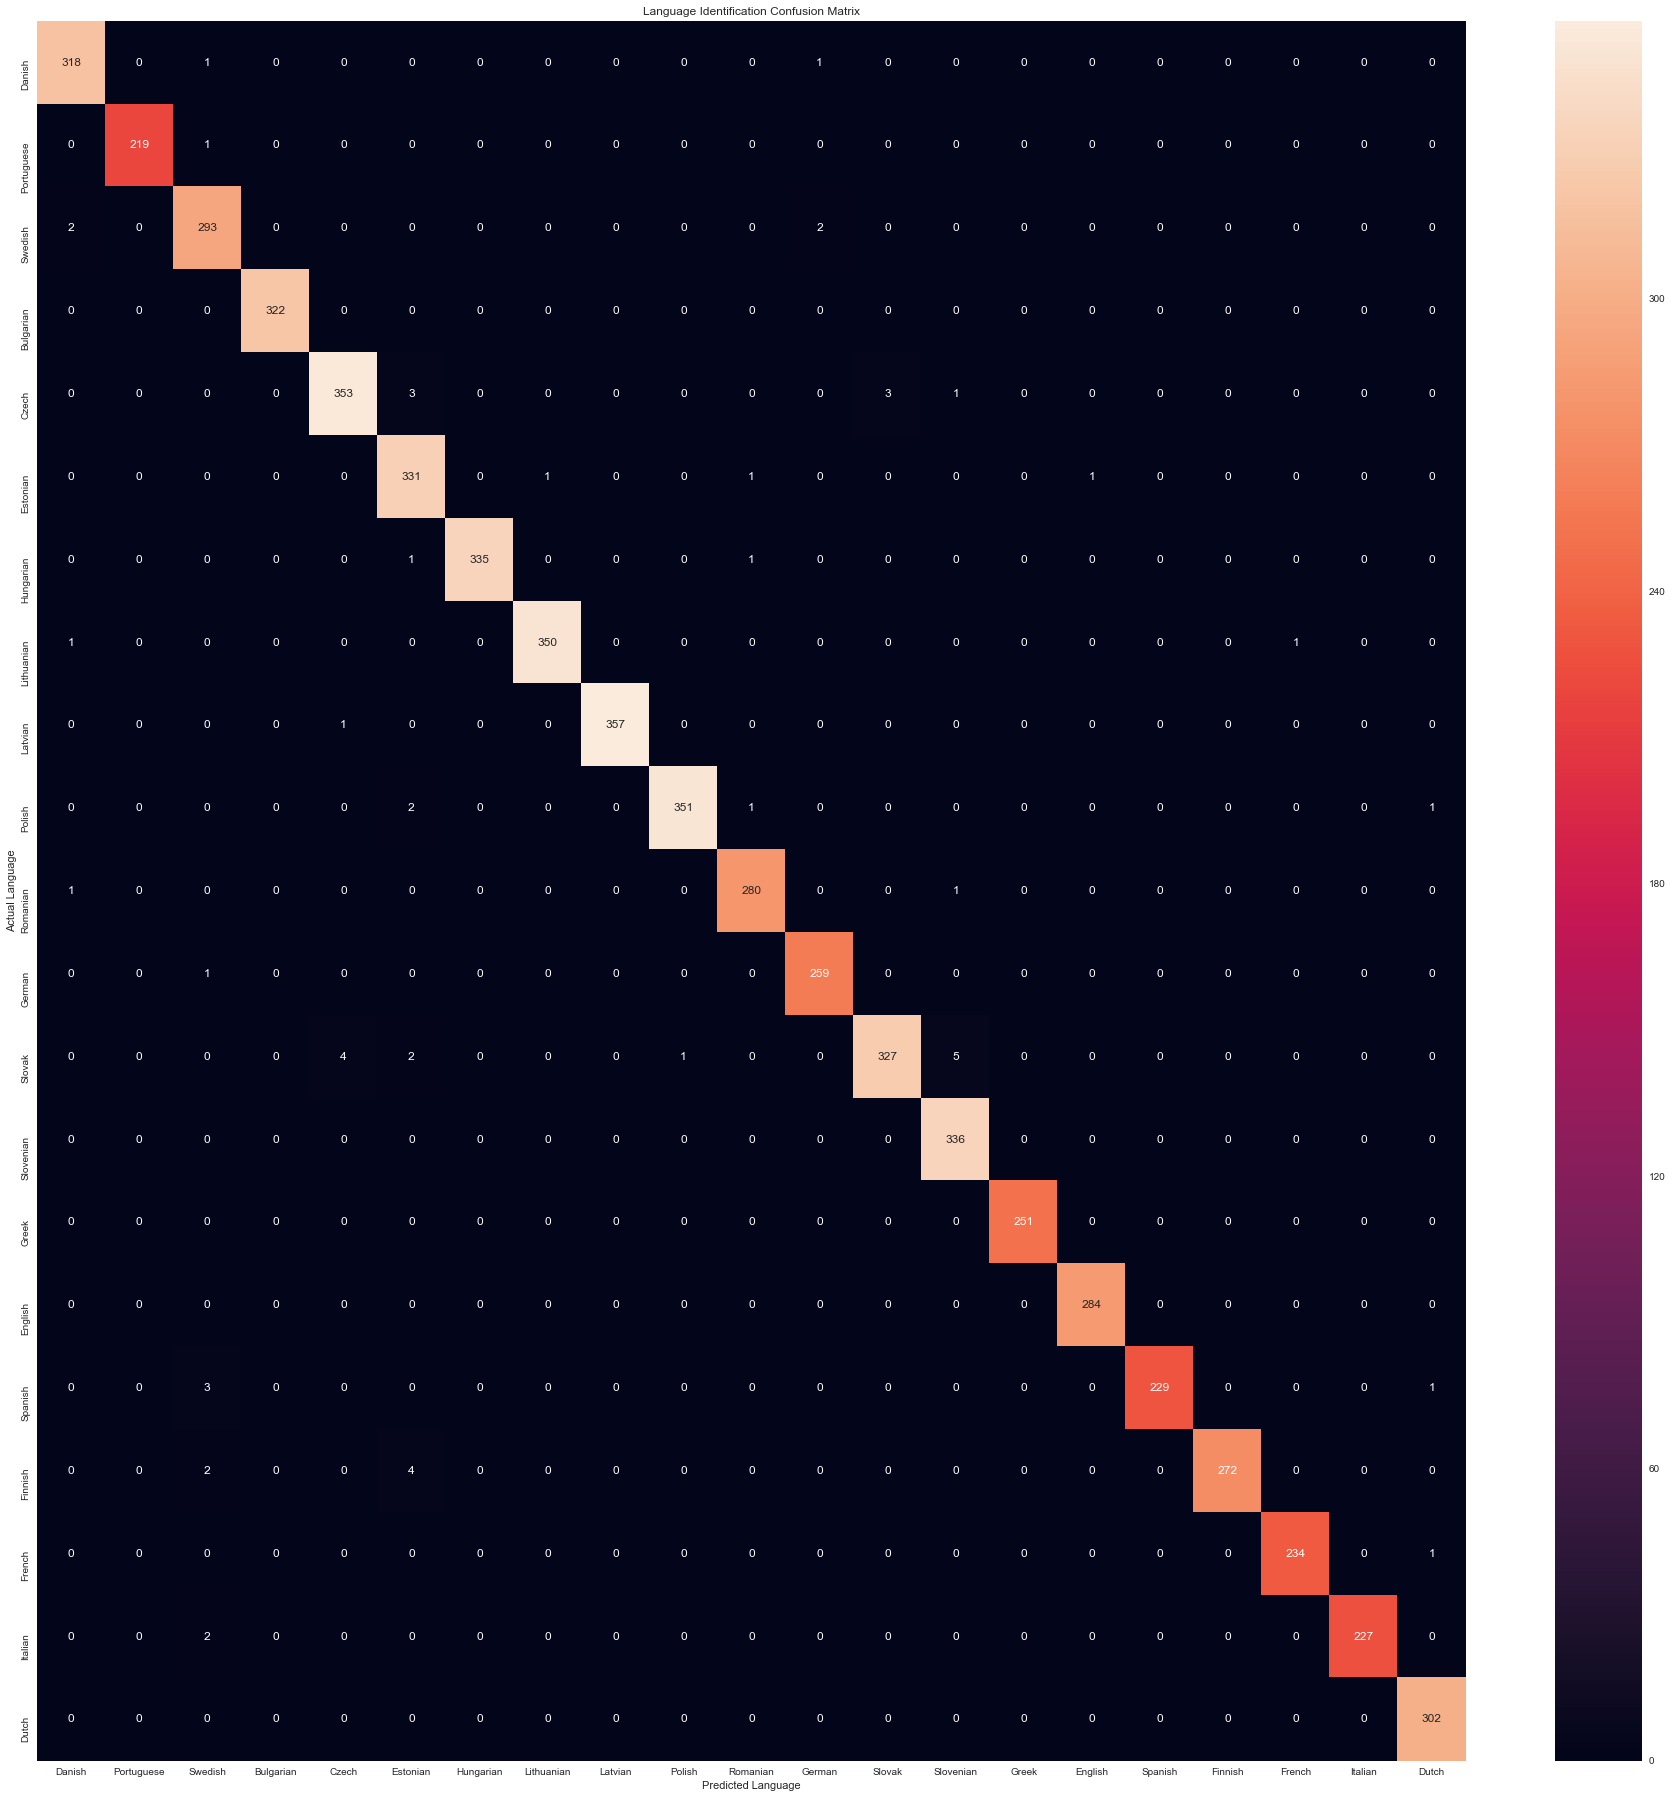

In [20]:
plt.show()